In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split



# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Numpy        : 1.23.5
Skimage      : 0.19.3
Tensorflow   : 2.14.0


In [2]:
!unzip Segmentation.v2i.png-mask-semantic_Road_anamoly.zip

Archive:  Segmentation.v2i.png-mask-semantic_Road_anamoly.zip
  inflating: Segmentation.v2i.png-mask-semantic_Road_anamoly/_classes.csv  
   creating: Segmentation.v2i.png-mask-semantic_Road_anamoly/test/
   creating: Segmentation.v2i.png-mask-semantic_Road_anamoly/test/images/
  inflating: Segmentation.v2i.png-mask-semantic_Road_anamoly/test/images/VID_20230526_095630197_mp4-17_jpg.rf.26cd5f517350c80897355e47eda18c7d.jpg  
  inflating: Segmentation.v2i.png-mask-semantic_Road_anamoly/test/images/VID_20230526_095630197_mp4-28_jpg.rf.ff3595264c1371ac4b601eeabd64f5fa.jpg  
  inflating: Segmentation.v2i.png-mask-semantic_Road_anamoly/test/images/VID_20230526_100415918_mp4-2_jpg.rf.de7eb0e14d8d030769b36cb65b7e622b.jpg  
  inflating: Segmentation.v2i.png-mask-semantic_Road_anamoly/test/images/VID_20230526_100415918_mp4-3_jpg.rf.c7ed375d1867cd190cefaee5d6675e33.jpg  
  inflating: Segmentation.v2i.png-mask-semantic_Road_anamoly/test/images/VID_20230526_100655083_mp4-14_jpg.rf.e692483a2b9c7699c

In [3]:
# learning rate
LR = 0.001
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

NUM_EPOCHS=25

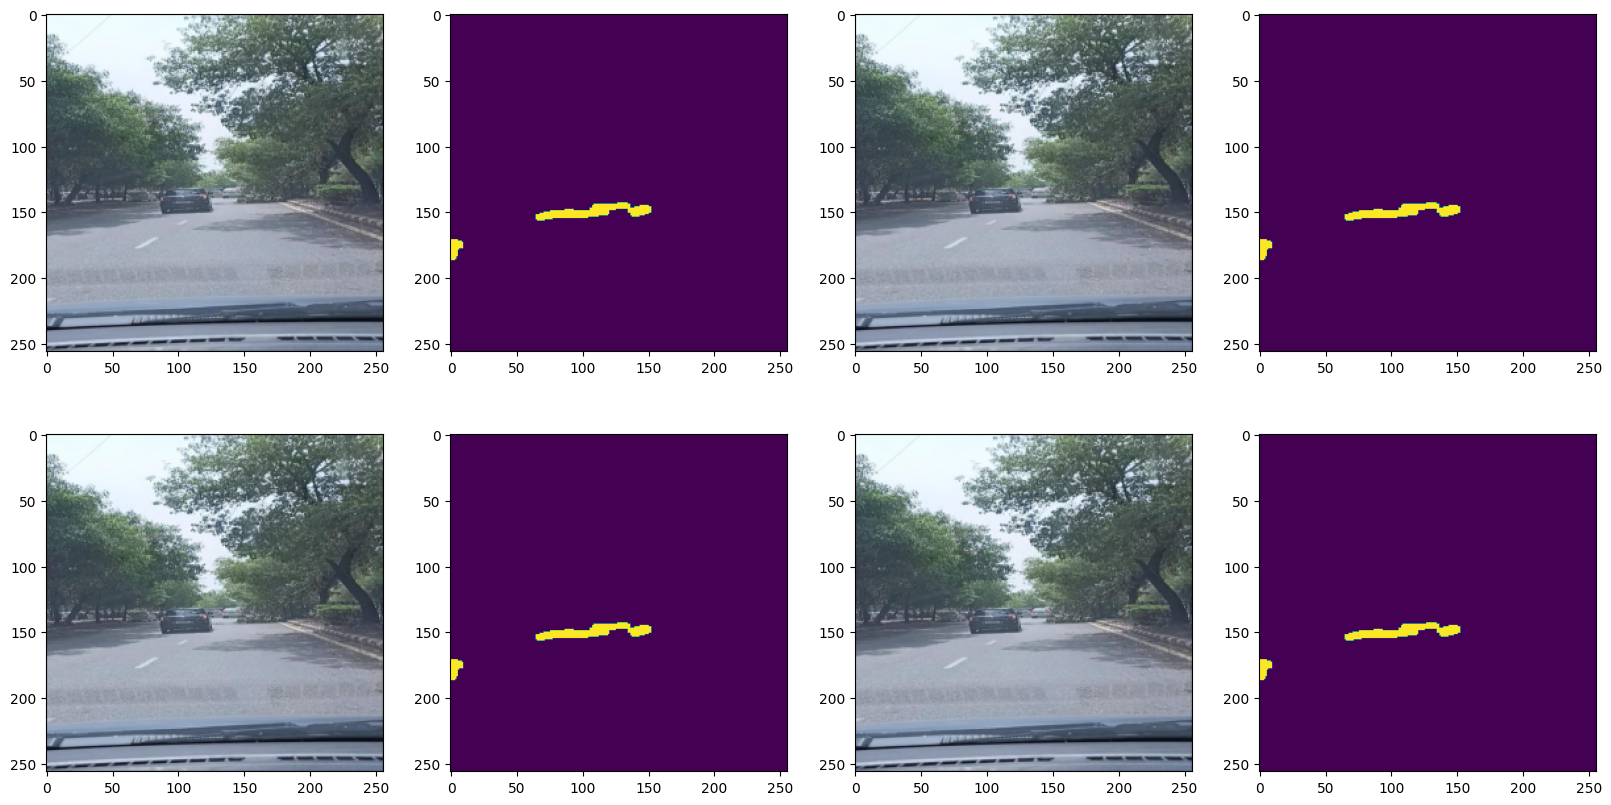

In [5]:
# to load the data, we will use the convenient skimage lib
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    #img_paths = ['{0}/Images/{1}'.format(path, id) for id in os.listdir(os.path.join(path,'Images'))]
    img_paths = [os.path.join(path, 'images', id) for id in os.listdir(os.path.join(path,'images'))]
    img_paths = [img_path for img_path in img_paths if img_path.endswith('.jpg')]

    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3],
                                                output_shape=output_shape,
                                                mode='constant',
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    return X_data

def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    #img_paths = [glob.glob('{0}/Masks/{1}'.format(path, id)) for id in (os.path.join(path,'Masks'))]
    img_paths = [os.path.join(path, 'masks', id) for id in os.listdir(os.path.join(path,'masks'))]
    img_paths = [img_path for img_path in img_paths if img_path.endswith('.png')]
    #print(img_paths)

    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool_)

    return Y_data

# Get training data
X_train = get_X_data('Segmentation.v2i.png-mask-semantic_Road_anamoly/train', output_shape=(IMG_HEIGHT,IMG_WIDTH))
# Get training data labels
Y_train = get_Y_data('Segmentation.v2i.png-mask-semantic_Road_anamoly/train', output_shape=(IMG_HEIGHT,IMG_WIDTH))

X_test = get_X_data('Segmentation.v2i.png-mask-semantic_Road_anamoly/test', output_shape=(IMG_HEIGHT,IMG_WIDTH))

TRAIN_PATH = 'Segmentation.v2i.png-mask-semantic_Road_anamoly/train'

# Check training data
train_ids = next(os.walk(TRAIN_PATH))

f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

axarr[0,2].imshow(X_train[ix])
axarr[0,3].imshow(np.squeeze(Y_train[ix]))

axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(np.squeeze(Y_train[ix]))

axarr[1,2].imshow(X_train[ix])
axarr[1,3].imshow(np.squeeze(Y_train[ix]))

plt.show()

In [7]:
#Image augmentation

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=13)

data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator()
X_datagen_val = ImageDataGenerator()
Y_datagen_val = ImageDataGenerator()

X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)
test_datagen.fit(X_test, augment=True, seed=13)
X_datagen_val.fit(x_test, augment=True, seed=13)
Y_datagen_val.fit(y_test, augment=True, seed=13)

X_train_augmented = X_datagen.flow(x_train,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train,  batch_size=15, shuffle=True, seed=13)
test_augmented = test_datagen.flow(X_test, shuffle=False, seed=13)
X_train_augmented_val = X_datagen_val.flow(x_test,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_test,  batch_size=15, shuffle=True, seed=13)

train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)

In [9]:
#Build a model

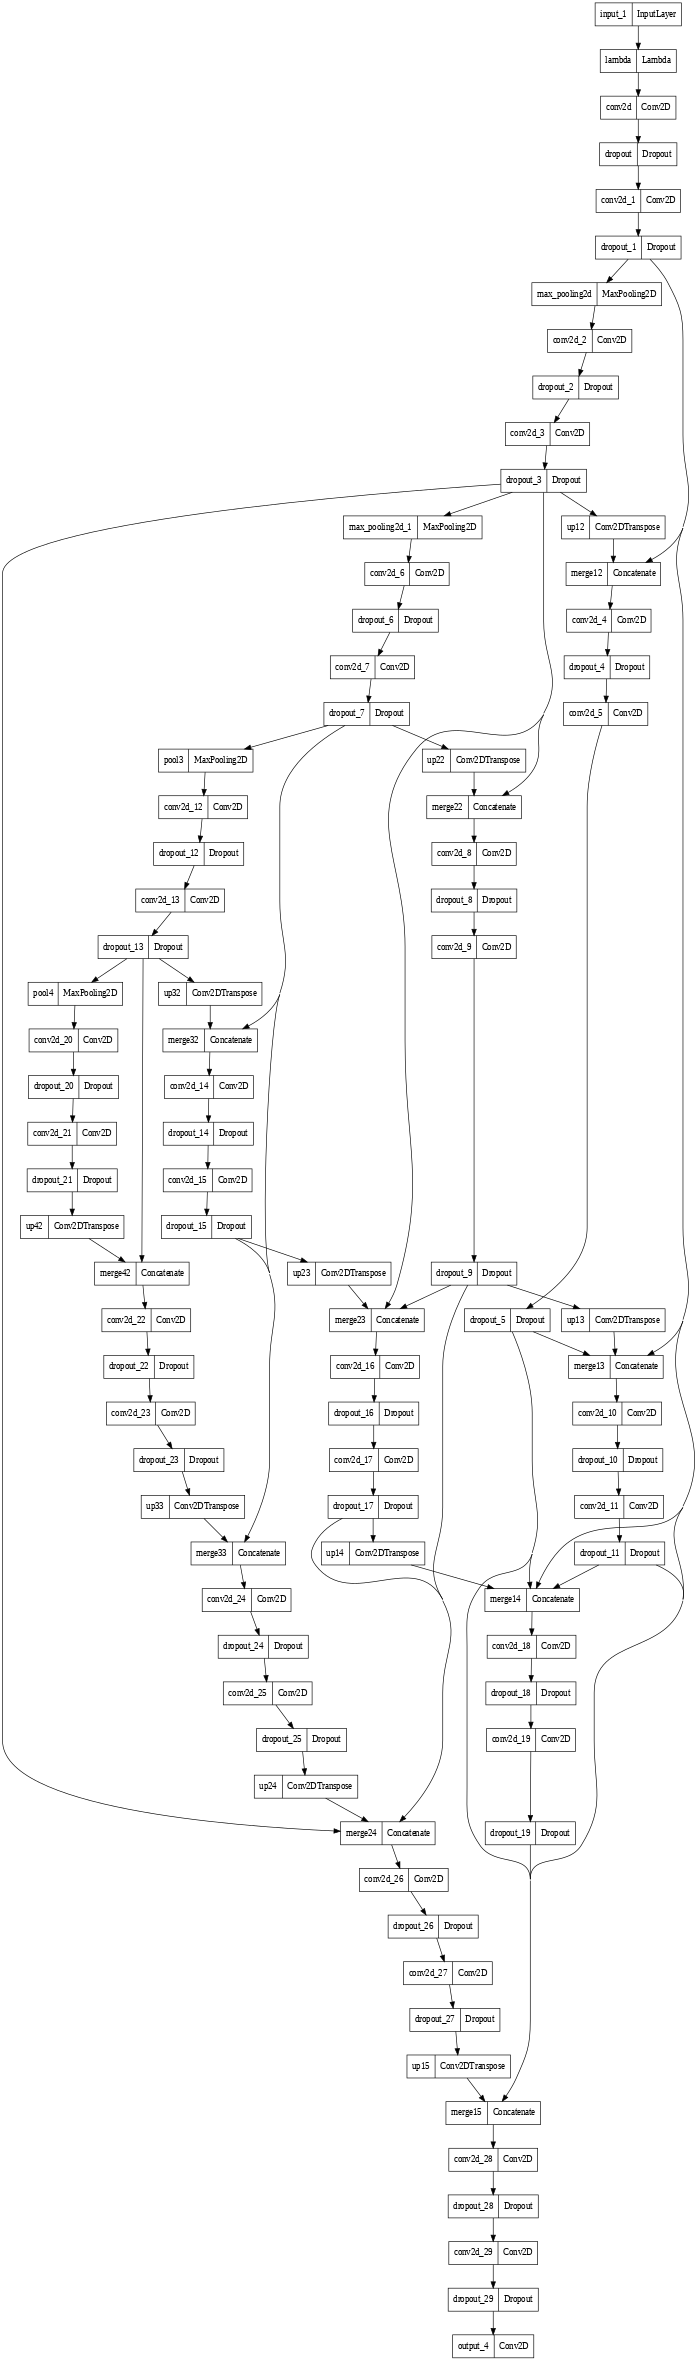

In [12]:
tf.keras.backend.clear_session()
nb_filter = [32,64,128,256,512]
# Build U-Net++ model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=bce_dice_loss, metrics=['accuracy'])

tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
    layer_range=None
)

In [11]:
#Running the model

In [13]:
NUM_EPOCHS = 15

In [14]:
checkpoint = ModelCheckpoint('best_model.hdf5' ,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005)

callbacks_list = [checkpoint, reduce_lr]

# Fit model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=len(X_train)/(6),
                    validation_steps=10,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS,
                    verbose=1,)

Epoch 1/15
136/136 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9189
Epoch 1: val_loss improved from inf to 0.07817, saving model to best_model.hdf5
136/136 [==============================] - 202s 1s/step - loss: 0.2120 - accuracy: 0.9189 - val_loss: 0.0782 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 2/15
136/136 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9336
Epoch 2: val_loss improved from 0.07817 to 0.04599, saving model to best_model.hdf5
136/136 [==============================] - 145s 1s/step - loss: 0.0705 - accuracy: 0.9336 - val_loss: 0.0460 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 3/15
136/136 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9404
Epoch 3: val_loss improved from 0.04599 to 0.04280, saving model to best_model.hdf5
136/136 [==============================] - 146s 1s/step - loss: 0.0567 - accuracy: 0.9404 - val_loss: 0.0428 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 4/15
136/136 [=========

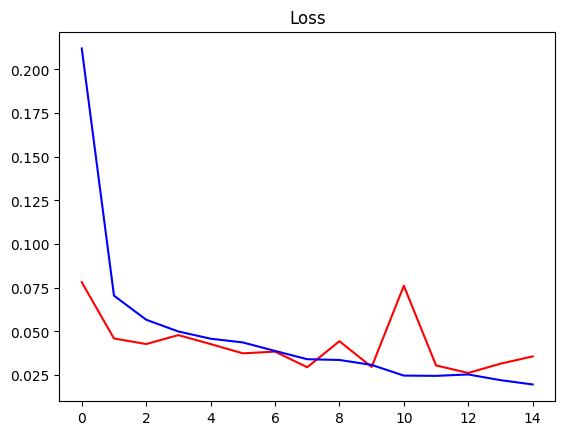

In [15]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()

plot_loss_history(history)

In [16]:
#Visualization of results

26/26 [==============================] - 12s 494ms/step


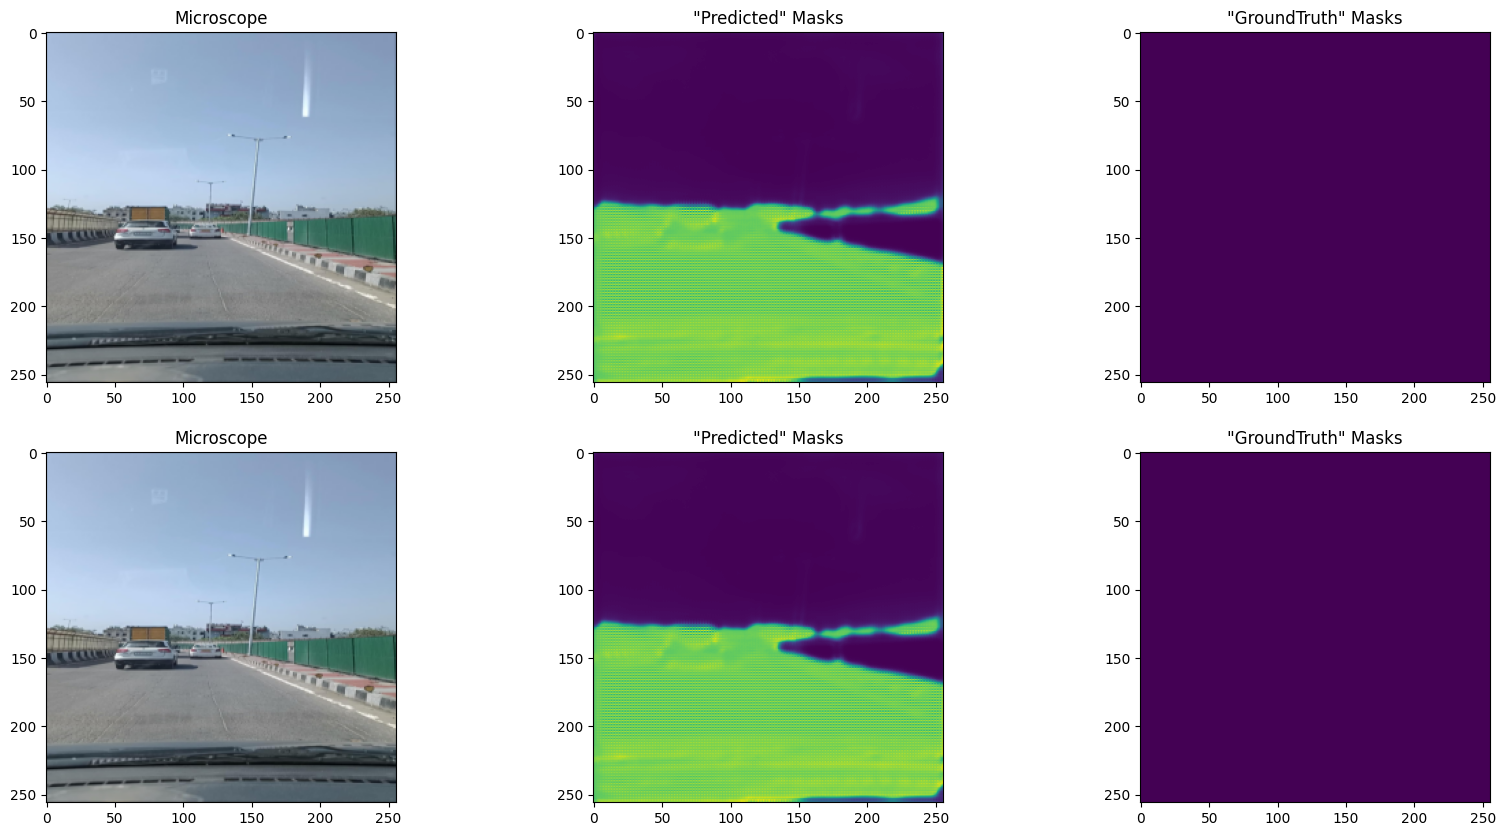

In [18]:
Y_predict = model.predict(X_train, verbose=1)
train_ids = next(os.walk('Segmentation.v2i.png-mask-semantic_Road_anamoly/train'))
test_ids = next(os.walk('Segmentation.v2i.png-mask-semantic_Road_anamoly/test'))
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')
axarr[0,2].imshow(np.squeeze(Y_train[ix]))
axarr[0,2].set_title('"GroundTruth" Masks')

axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')
axarr[1,2].imshow(np.squeeze(Y_train[ix]))
axarr[1,2].set_title('"GroundTruth" Masks')

plt.show()

5/5 [==============================] - 5s 1s/step
(256, 256, 3)


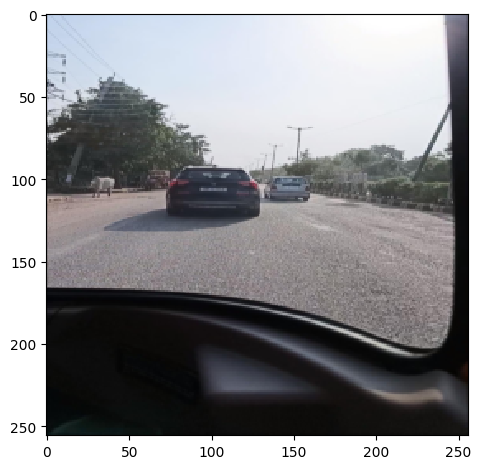

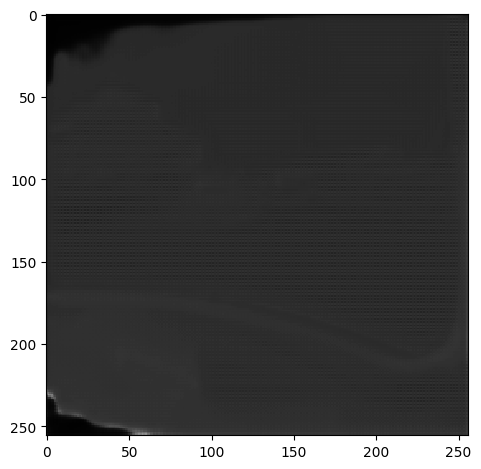

In [19]:
# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show();
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show();